Notebook to read and plot post-processed precipitation efficiency (from pickle files) in Rosi's MPAS aquaplanet simulations

### Main settings

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from scipy import stats
import numpy as np
import xarray as xr
from statannotations.Annotator import Annotator

In [2]:
# pickle_dir = f"/glade/campaign/univ/uokl0049/jruppert/pickle_out"
pickle_dir = '../../../pickle_out/aquaplanet'
test_names = ["CTL","HOMO_RAD","CLIM_RAD"]
# test_names = ["CTL","HOMO_RAD"]
ntest = len(test_names)
pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN', 'DSA']
pclass_names_long = ['DeepC', 'Congest', 'Shallow', 'Stratiform', 'Anvil', 'DSA']
# pclass_names=["Deep", "Congestus", "Shallow", "Stratiform", "Anvil"]#, "DSA"] # DSA isn't there yet
nclass = len(pclass_names)

### Read data

In [3]:
# Get list of files
def get_file_list():
    # Get list of desired file times
    file_times_arr = np.arange('2000-05-01T06:00:00', '2000-05-11T06:00:00',
                               6, dtype='datetime64[h]')
    file_times = [file_times_arr[i].astype('datetime64[D]').astype(str)+'_'+str(file_times_arr[i]).split('T')[1].split(':')[0]+'.00.00' for i in range(len(file_times_arr))]
    ntime = len(file_times)
    times = np.arange(ntime)/4 #+ 1.25
    return file_times, times

file_times, times = get_file_list()
ntime = len(times)

In [4]:
# Read grid data
do_write_grid = False
grid_pickle_file = f"{pickle_dir}/grid_data.pickle"
if do_write_grid:
    import xarray as xr
    grid_path = "/glade/work/rberrios/MPAS/aqua_sstmax10N_ASD/plus4K/TC_3km/x5.tropical_3km_10N.init.nc"
    grid = xr.open_dataset(grid_path)
    areaCell = grid.areaCell
    latCell = np.degrees(grid.latCell)
    lonCell = np.degrees(grid.lonCell)
    with open(grid_pickle_file, 'wb') as f:
        pickle.dump([areaCell, latCell, lonCell], f)
else:
    with open(grid_pickle_file, 'rb') as f:
        areaCell, latCell, lonCell = pickle.load(f)

latbounds_all = [
    [0, 15.0],
    [15, 20],
]

# Get total cell counts within lat bounds for area normalization
tot_cellcount_all = []
for latbounds in latbounds_all:
    ind_within_lat = np.where( (latCell >= latbounds[0]) & (latCell <= latbounds[1]) )[0]
    tot_cellcount_all.append(len(ind_within_lat))

In [5]:
nsubset = 2
# dims = (ntest, nclass, ntime)
dims = (nsubset, ntest, nclass, ntime)
pclass_area = np.full(dims, np.nan)
mu = np.full(dims, np.nan)
md = np.full(dims, np.nan)

for isubset in range(nsubset):
    latbounds = latbounds_all[isubset]
    for iexp in range(ntest):
        for it, time in enumerate(file_times):
            pickle_file = f"{pickle_dir}/VMF_pclass_{test_names[iexp]}_{time}_{str(int(latbounds[0]))}-{str(int(latbounds[1]))}.0.pickle"
            try:
                with open(pickle_file, 'rb') as f:
                    file = pickle.load(f)
                for iname in pclass_names:
                    # mu[expName][iname] = []
                    # Read in variables from pickle
                    # for iclass in range(nclass):
                    pclass_area[isubset, iexp,:,it] = file[0]
                    mu[isubset, iexp,:,it] = file[1]
                    md[isubset, iexp,:,it] = file[2]
            except:
                pass

# for iclass in range(nclass):
#     # print(pclass_names[iclass], np.mean(pclass_area[0,iclass,:]))
#     # print(pclass_names[iclass], np.mean(mu[0,iclass,:]))
#     print(pclass_names[iclass], mu[0,iclass,-1])

#### PClass fraction

In [6]:
tot_area = np.sum(pclass_area, axis=2)
pclass_frac = np.copy(pclass_area)
for isubset in range(nsubset):
    tot_cellcount = tot_cellcount_all[isubset]
    for iclass in range(nclass):
        # pclass_frac1[:,iclass,:] = 1e2*pclass_area[:,iclass,:] / tot_area
        pclass_frac[isubset,:,iclass,:] = 1e2*pclass_area[isubset,:,iclass,:] / tot_cellcount
        # print(pclass_names[iclass],
        #       np.mean(pclass_area[0,iclass,:]),
        #       np.mean(pclass_frac1[0,iclass,:]),
        #       np.mean(pclass_frac2[0,iclass,:]))

### Plotting

#### Time series

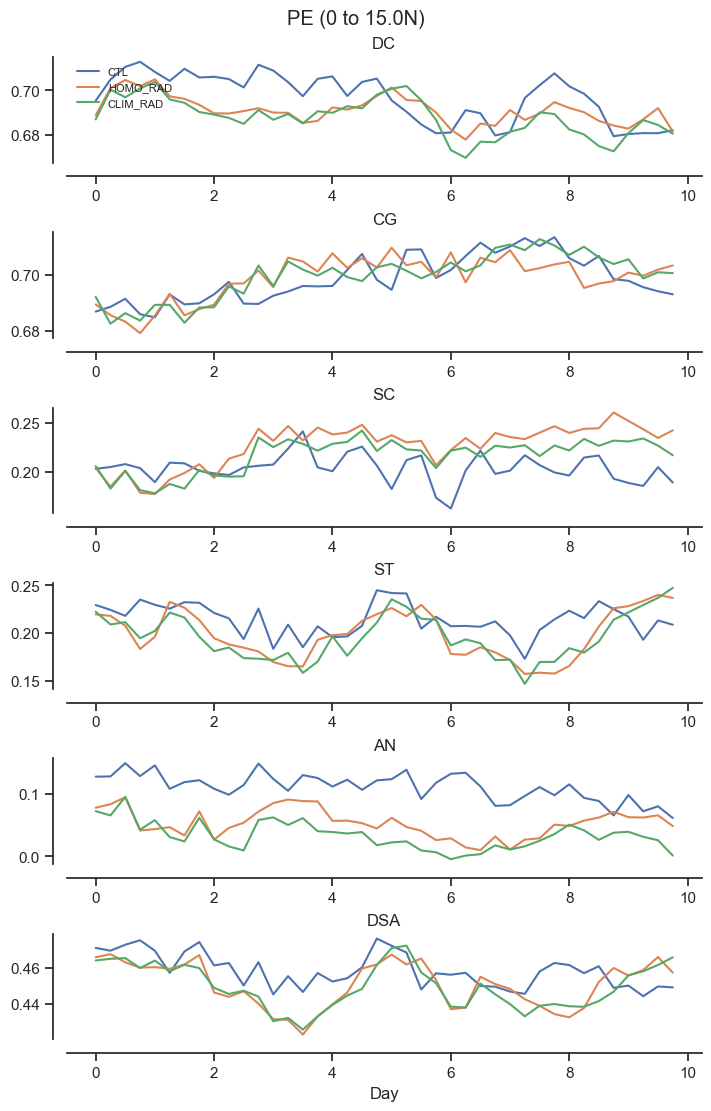

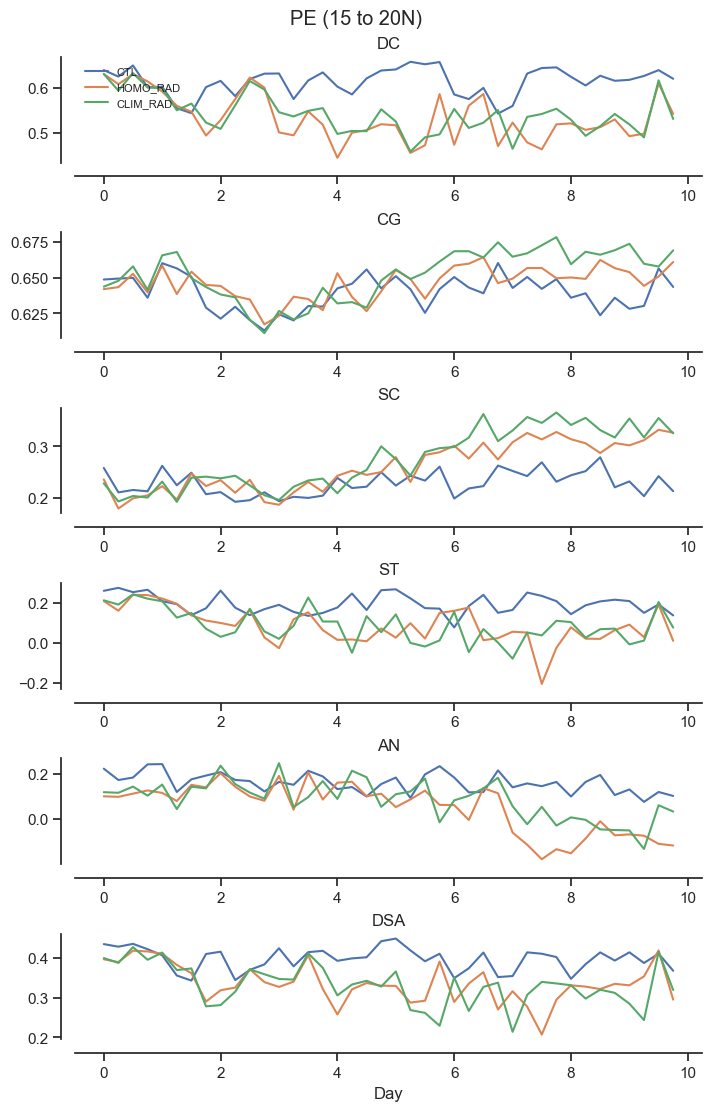

In [19]:
# Plot line plot with PE for both tests
def line_plot(plot_var, title):

    pclass_plot = [0,3,4,5]
    pclass_plot = [0,1,2,3,4,5]
    nclass_plot = len(pclass_plot)

    # sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
    sns.set_theme(style="ticks", rc={'xtick.bottom': True, 'ytick.left': True})#, "axes.spines.right": False, "axes.spines.top": False})
    # sns.set_theme(style="dark")
    fig_x = 7
    fig_y = 11
    fig, axs = plt.subplots(nclass_plot, 1,figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    sns.set_palette('muted')
    # title = r'$\epsilon = 1 - M_d / M_u$'
    plt.suptitle(title)
    # units = '-'

    xdim = np.arange(ntime)/4

    for ipclass in range(nclass_plot):

        axs[ipclass].set_title(pclass_names[pclass_plot[ipclass]])
        for i, legend in enumerate(test_names):
            ivar = plot_var[i,pclass_plot[ipclass],:]
            # ivar_smooth, confidence_interval, nwindow = running_mean_conf(ivar)
            # ax.plot(times_3d, ivar, label=legend, linewidth=1.5)
            # x_smoothed = times_3d[nwindow//2:-nwindow//2+1]
            axs[ipclass].plot(xdim, ivar, label=legend, linewidth=1.5)
            # axs[ipclass].plot(x_smoothed, ivar_smooth, label=legend, linewidth=1.5)
            # axs[ipclass].fill_between(x_smoothed,
            #     # ivar_smooth - confidence_interval[0],
            #     # ivar_smooth + confidence_interval[1],
            #     ivar_smooth - confidence_interval,
            #     ivar_smooth + confidence_interval,
            #     alpha=0.4,label="95% CI",)
        sns.despine(offset=10,ax=axs[ipclass])#, left=True, bottom=True)
        # ax.spines['left'].set_visible(False)

    axs[-1].set_xlabel('Day')

    axs[0].legend(loc='upper left', fontsize=8, frameon=False)
    plt.show()
    plt.close()
    return None

for isubset in range(nsubset):
    pe = 1 - (-md[isubset]/mu[isubset])
    title = f'PE ({latbounds_all[isubset][0]} to {latbounds_all[isubset][1]}N)'
    line_plot(pe, title)

#### Boxplots

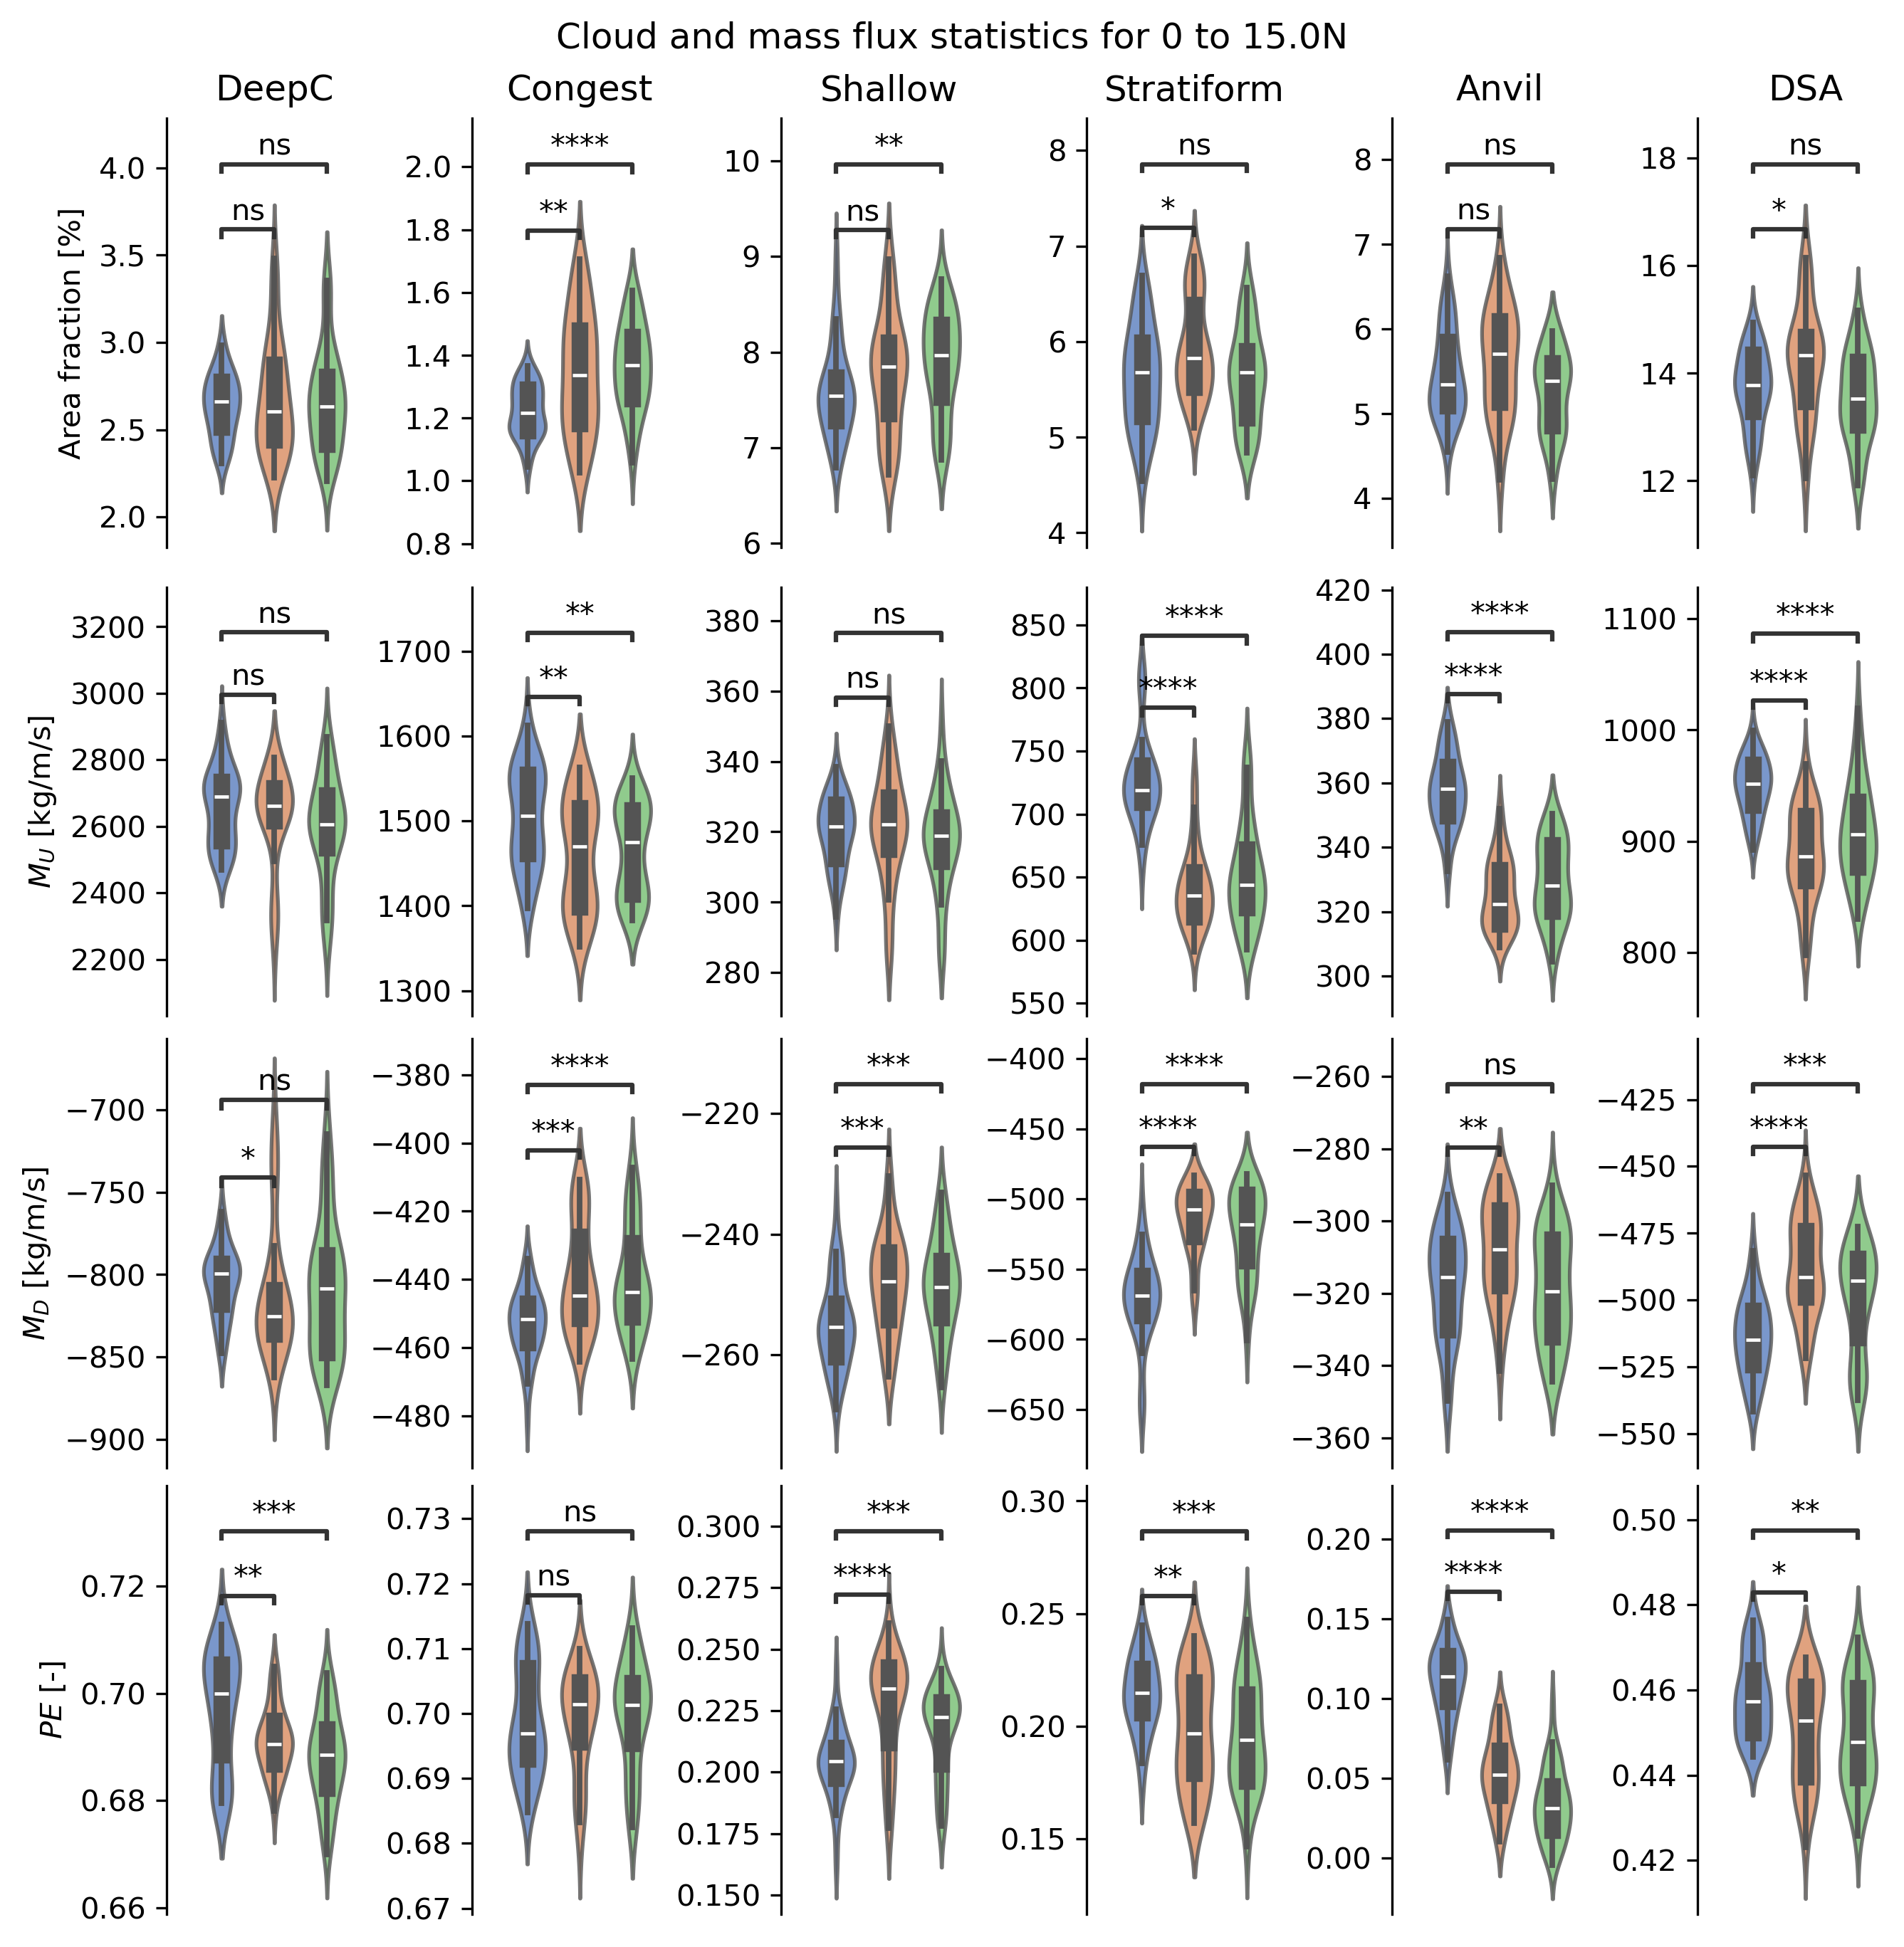

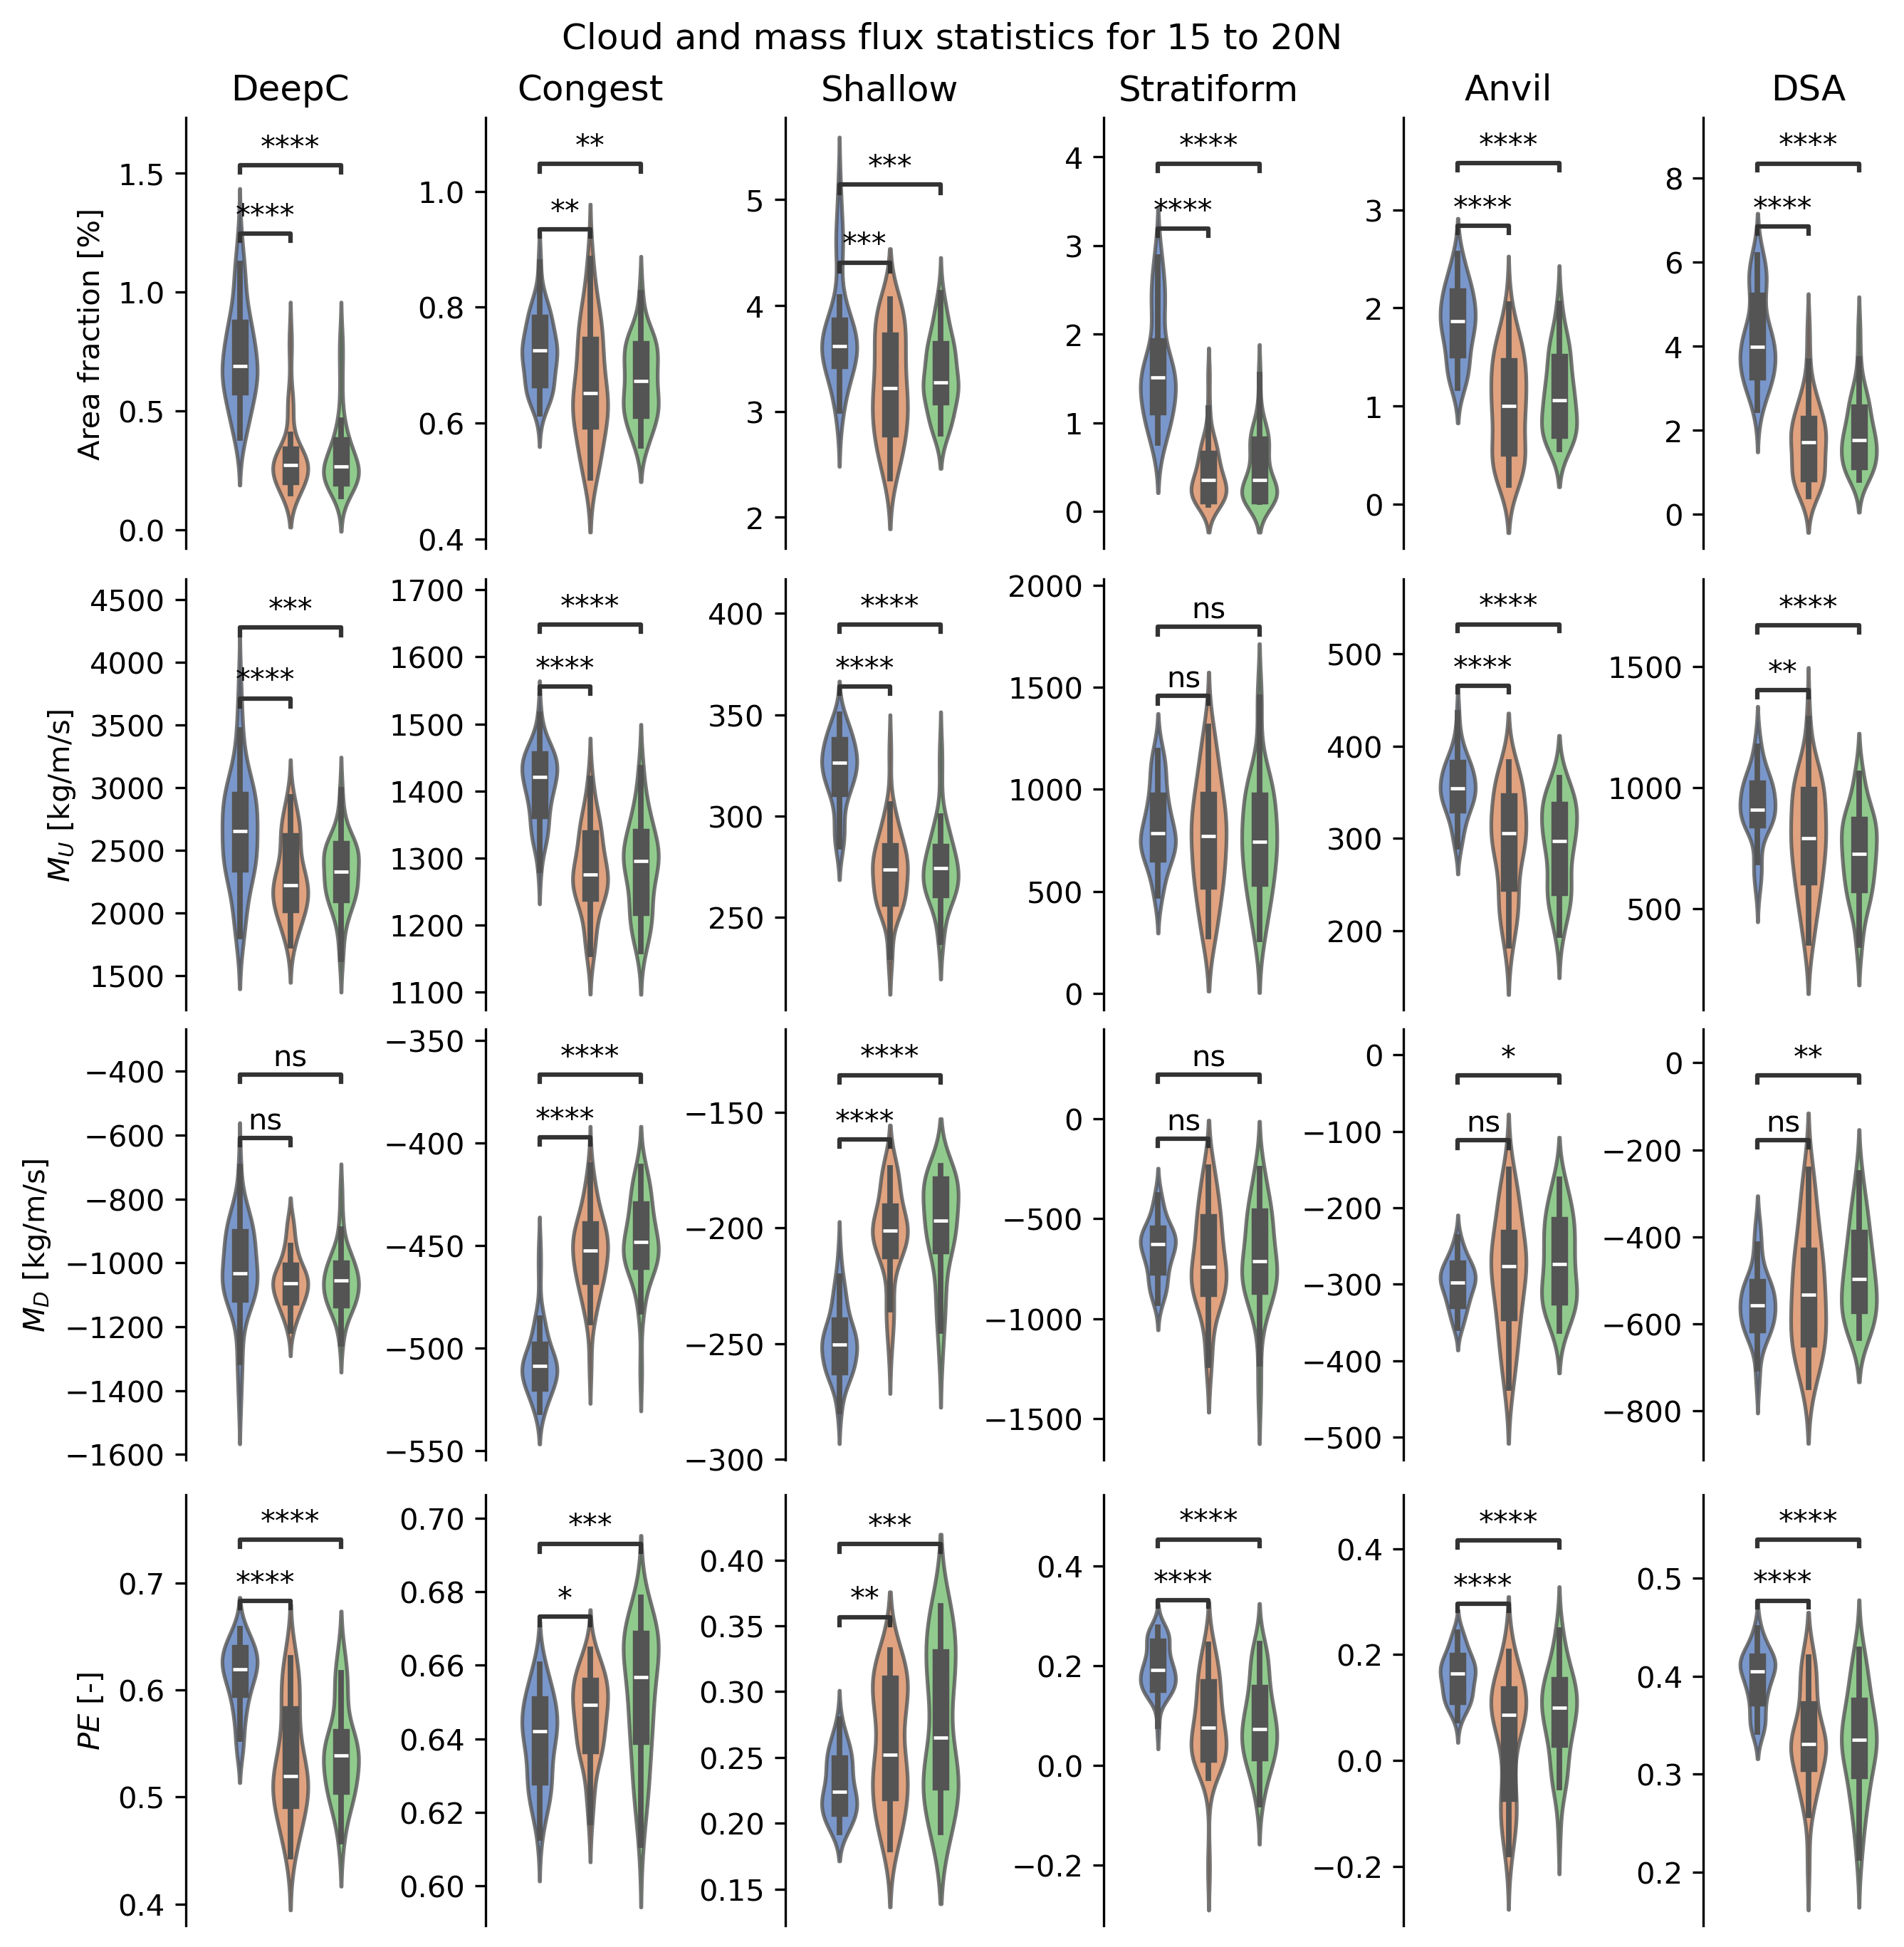

In [11]:
def plot_boxplots(pltvar, axs, do_legend=False):
      colors = sns.color_palette('muted', n_colors=ntest)
      for iclass, iax in enumerate(axs):
            # sns.boxplot([pltvar[iexp,iclass,:] for iexp in range(pltvar.shape[0])],
            #             width=0.7, showmeans=True,
            #             meanprops={"marker":"o", "markerfacecolor":"white",
            #                   "markeredgecolor":"black", "markersize":"6"},
            #             palette=colors,
            #             ax=iax, notch=True, showcaps=False, bootstrap=10000,
            #             showfliers=True,)
            sns.violinplot([pltvar[iexp,iclass,:] for iexp in range(pltvar.shape[0])],
                           width=0.7, palette=colors, alpha=0.8,
                           inner="box", #split=True,
                           gap=0.01, ax=iax)

            # Annotate with significance
            pairs = [(0, 1), (0, 2)]
            annotator = Annotator(iax, pairs, data=[pltvar[iexp,iclass,:] for iexp in range(pltvar.shape[0])])
            annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
            annotator.apply_and_annotate()

            # Add t-test
            # t_stat, p_value = ttest_ind(pltvar[0,iclass,:],
            #                         pltvar[1,iclass,:],
            #                         equal_var=True)
            # iax.text(0.5, -0.11, str(np.round(p_value, 3)),
            #          ha='center', va='top', transform=iax.transAxes)#, fontsize=10)
      # if do_legend:
      #       axs[-1].legend(loc="upper right", frameon=False, fontsize=12, labels=test_names, bbox_to_anchor=(1.15, 0.5))
      #       handles = [plt.Line2D([0], [0], color=colors[i], lw=10) for i in range(ntest)]
      #       axs[-1].legend(handles=handles, labels=test_names, loc="center right", frameon=False,
      #                      fontsize=12, bbox_to_anchor=(5.0, 0.5))
      return axs

for isubset in range(nsubset):

      latbounds = latbounds_all[isubset]
      title = f"Cloud and mass flux statistics for {latbounds[0]} to {latbounds[1]}N"

      # it_max = len(times)
      it_max = np.max(np.where(~np.isnan(pclass_frac[isubset,2,0,:]))[0]) + 1

      # create figure
      fig_x = 1.3*nclass + 1
      fig_y = 9
      fig, axs = plt.subplots(4,nclass, figsize=(fig_x,fig_y), layout="constrained", dpi=300)

      title = f"Cloud and mass flux statistics for {latbounds[0]} to {latbounds[1]}N"
      fig.suptitle(title)

      # PClass Area
      pltvar = pclass_frac[isubset]
      ytitle = 'Area fraction [%]'
      irow = 0
      axs[irow, 0].set_ylabel(ytitle)
      # plot_boxplots(pltvar, axs.flatten()[0:nclass], ntest, it_max, ytitle, do_legend=True)
      axs[irow,:] = plot_boxplots(pltvar[:,:,:it_max], axs[irow,:])

      # M_U
      pltvar = mu[isubset]
      ytitle = '$M_U$ [kg/m/s]'
      # plot_boxplots(pltvar, axs.flatten()[nclass:nclass*2], ntest, it_max, ytitle, do_legend=True)
      irow = 1
      axs[irow, 0].set_ylabel(ytitle)
      axs[irow,:] = plot_boxplots(pltvar[:,:,:it_max], axs[irow,:])

      # M_D
      pltvar = md[isubset]
      ytitle = '$M_D$ [kg/m/s]'
      # plot_boxplots(pltvar, axs.flatten()[nclass*2:nclass*3], ntest, it_max, ytitle)
      irow = 2
      axs[irow, 0].set_ylabel(ytitle)
      axs[irow,:] = plot_boxplots(pltvar[:,:,:it_max], axs[irow,:])

      # PE
      pltvar = 1 - (-md[isubset]/mu[isubset])
      ytitle = '$PE$ [-]'
      # plot_boxplots(pltvar, axs.flatten()[nclass*3:nclass*4], ntest, it_max, ytitle)
      irow = 3
      axs[irow, 0].set_ylabel(ytitle)
      axs[irow,:] = plot_boxplots(pltvar[:,:,:it_max], axs[irow,:])

      for iclass in range(nclass):
            axs[0,iclass].set_title(pclass_names_long[iclass])

      for iaxs in axs.flatten():
            sns.despine(offset=10,ax=iaxs, top=True, right=True, bottom=True)
            iaxs.set_xticks([])

      # axs[1,nclass-1].legend(loc="upper right", labels=test_names,
      #                        frameon=False, fontsize=12, bbox_to_anchor=(1.15, 0.5))

      plt.show()
      plt.close()